<a href="https://colab.research.google.com/github/WhatRaSudeep/SAiDL-Spring-Assignment-2024/blob/main/VAE/VAEAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this jupyter notebook, we will train a variational autoencoder for reconstructing a greyscale image from the MNIST dataset

source: https://github.com/debtanu177/CVAE_MNIST/blob/master/train_vae.py

Goal: Compress the data as much as possible.

Idea: While sparse representations can be efficiently stored using CSC/CSR formats, it is desired that the representations obtained have low ranks. Ideally, the dimension of the latent vectors has to be set as small as possible so that both sparsity and rank conditions are satisfied. However, one of the practical issues with setting the latent dimension too low is the quality of the reconstruction is poor. Another practical issue is that optimization is easier in higher dimensions. These issues do not occur on simple datasets such as MNIST but can be an issue for datasets such as CIFAR10, CIFAR100, ImageNet etc. An alternate way is to use a reasonably large latent dimension but enforcing low rank on the space. PCA can be applied to low rank representations to efficiently store and approximately reconstruct the latent vectors. As the architecture (along with the learnt parameter values i.e. checkpoint model) approximately takes the same memory irrespective of the latent dimension chosen, the goal is achieved if low rank latent vectors can be learnt.

Modify the loss function of the variational autoencoder - an additional term is added to penalize the rank of the latent vectors. As minimizing the rank of a matrix directly is difficult, the options are


1) Nuclear norm to upper bound the rank of the latent space
2) use a log-det approach and set up MM using a linear function as an upper bound (hint: see example 1 in the survey paper on MM)



Instructions:

The LitVAE class defined below contains the implementation of the baseline i.e. the VAE from the source mentioned above. However, the nuclear norm loss and the majorizer loss are currently set as zeros in both the training and validation steps. Modify the code to implement these ideas correctly

In [1]:
# basic libraries
import matplotlib.pyplot as plt
import numpy as np

# torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# lightning libraries
!pip install lightning
import lightning.pytorch as pl
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.2 MB/s eta 0:00:00


In [2]:
class LitVAE(pl.LightningModule):
    def __init__(self, latent_dim=5, lambda_nuc=1e+2, lambda_majorizer=9e-1, regularization='nuc'):
        super(LitVAE, self).__init__()
        self.latent_dim = latent_dim
        self.lambda_nuc = lambda_nuc
        self.lambda_majorizer = lambda_majorizer
        self.regularization = regularization

        # For Encoder
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.linear1 = nn.Linear(4 * 4 * 32, 300)
        self.mu = nn.Linear(300, self.latent_dim)
        self.logvar = nn.Linear(300, self.latent_dim)

        # For Decoder
        self.linear2 = nn.Linear(self.latent_dim, 300)
        self.linear3 = nn.Linear(300, 4 * 4 * 32)
        self.conv3 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2)
        self.conv4 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2)
        self.conv5 = nn.ConvTranspose2d(1, 1, kernel_size=4)

        # Loss function
        self.criterion = nn.MSELoss(reduction="sum")

    def encode(self, x):
        t = F.relu(self.conv1(x))
        t = F.relu(self.conv2(t))
        t = t.reshape((x.shape[0], -1))
        t = F.relu(self.linear1(t))
        mu = self.mu(t)
        logvar = self.logvar(t)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        t = F.relu(self.linear2(z))
        t = F.relu(self.linear3(t))
        t = t.reshape((z.shape[0], 32, 4, 4))
        t = F.relu(self.conv3(t))
        t = F.relu(self.conv4(t))
        t = F.relu(self.conv5(t))
        return t

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        pred = self.decode(z)
        return pred, mu, logvar, z

    def nuclear_norm_loss(self, latent):
        latent_flat = latent.view(latent.size(0), -1)  # Flatten the latent vectors
        return torch.norm(latent_flat, p='nuc')

    def log_det_loss(self, latent):
        latent_flat = latent.view(latent.size(0), -1)  # Flatten the latent vectors
        u, s, v = torch.svd(latent_flat)
        majorizer_loss = torch.sum(s/(s.detach() +1e-5))  # Add a small value to avoid division by zero
        return majorizer_loss

    def training_step(self, batch, batch_idx):
        img, _ = batch
        output, mu, logvar, latent = self(img)
        # Compute the MSE loss
        mse_loss = self.criterion(output, img)
        # Compute the KL divergence
        kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        # Compute the nuclear norm loss
        rank_loss = self.nuclear_norm_loss(latent)
        # Compute the log-det loss
        majorizer = self.log_det_loss(latent)
        # Total loss
        if self.regularization == 'nuc':
            loss = mse_loss + kl_div + self.lambda_nuc * rank_loss
        elif self.regularization == 'majorizer':
            loss = mse_loss + kl_div + self.lambda_majorizer * majorizer
        else:
            loss = mse_loss + kl_div
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        img, _ = batch
        output, mu, logvar, latent = self(img)
        # Compute the MSE loss
        mse_loss = self.criterion(output, img)
        # Compute the KL divergence
        kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        # Compute the nuclear norm loss
        rank_loss = self.nuclear_norm_loss(latent)
        # Compute the log-det loss
        majorizer = self.log_det_loss(latent)
        # Total loss
        if self.regularization == 'nuc':
            loss = mse_loss + kl_div + self.lambda_nuc * rank_loss
        elif self.regularization == 'majorizer':
            loss = mse_loss + kl_div + self.lambda_majorizer * majorizer
        else:
            loss = mse_loss + kl_div
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-3)
        return optimizer


In [3]:
# set the data path

# Data Module
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=512):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.num_workers = 14

    def prepare_data(self):
        torchvision.datasets.MNIST(root="./data/", train=True, download=True)
        torchvision.datasets.MNIST(root="./data/", train=False, download=True)

    def setup(self, stage=None):
        self.mnist_train = torchvision.datasets.MNIST(
            root="./data/", train=True, transform=self.transform
        )
        self.mnist_val = torchvision.datasets.MNIST(
            root="./data/", train=False, transform=self.transform
        )

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)


# Visualize the results
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

First we try the baseline i.e. without imposing any constraints on the rank of the latent vectors

In [4]:
# Initialize the data module and model
mnist_dm = MNISTDataModule(batch_size=64)
vae = LitVAE(latent_dim=50)


# Train the model
trainer = pl.Trainer(
    min_epochs=10,
    max_epochs=30,
    enable_progress_bar=False
)
trainer.fit(vae, mnist_dm)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 935916.77it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 131930.94it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1091782.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3344545.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 416    | train
1  | conv2     | Conv2d          | 12.8 K | train
2  | linear1   | Linear          | 153 K  | train
3  | mu        | Linear          | 15.1 K | train
4  | logvar    | Linear          | 15.1 K | train
5  | linear2   | Linear          | 15.3 K | train
6  | linear3   | Linear          | 154 K  | train
7  | conv3     | ConvTranspose2d | 12.8 K | train
8  | conv4     | ConvTranspose2d | 401    | train
9  | conv5     | ConvTranspose2d | 17     | train
10 | criterion | MSELoss         | 0      | train
-------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in

Original Images


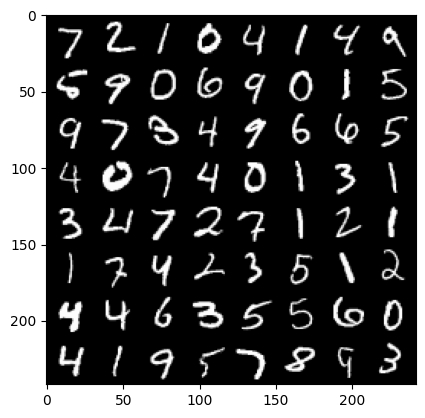

Reconstructed Images


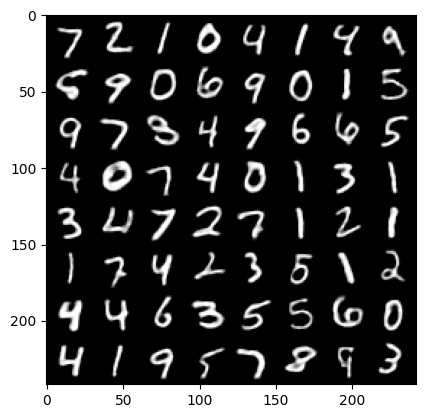

tensor(50)


In [5]:
# Get a batch of test images
images, _ = next(iter(mnist_dm.val_dataloader()))


# Get the reconstructed images
vae.eval()
with torch.no_grad():
    reconstructed, _, _, latent = vae(images)

# Show original images
print("Original Images")
imshow(torchvision.utils.make_grid(images))

# Show reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed))

# save the images and the corresponding reconstructions
torchvision.utils.save_image(images, "original.png")
torchvision.utils.save_image(reconstructed, "reconstructed.png")

# compute the rank of the latent matrix
rank = torch.linalg.matrix_rank(latent)

print(rank)

# delete the model
del vae

Now, we try adding the nuclear loss as a regularization

In [6]:
# Initialize the data module and model
mnist_dm = MNISTDataModule(batch_size=64)
vae = LitVAE(latent_dim=50, regularization="nuc")

# Train the model
trainer = pl.Trainer(
    min_epochs=10,
    max_epochs=30,
    enable_progress_bar =True
)
trainer.fit(vae, mnist_dm)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 416    | train
1  | conv2     | Conv2d          | 12.8 K | train
2  | linear1   | Linear          | 153 K  | train
3  | mu        | Linear          | 15.1 K | train
4  | logvar    | Linear          | 15.1 K | train
5  | linear2   | Linear          | 15.3 K | train
6  | linear3   | Linear          | 154 K  | train
7  | conv3     | ConvTransp

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Original Images


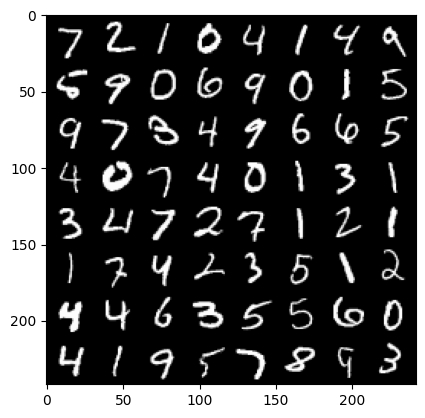

Reconstructed Images


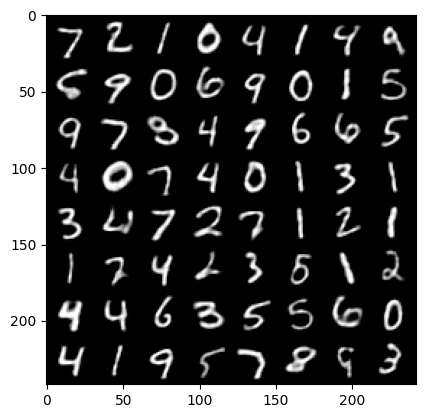

tensor(50)


In [7]:
# Get a batch of test images
images, _ = next(iter(mnist_dm.val_dataloader()))


# Get the reconstructed images
vae.eval()
with torch.no_grad():
    reconstructed, _, _, latent = vae(images)

# Show original images
print("Original Images")
imshow(torchvision.utils.make_grid(images))

# Show reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed))

# save the images and the corresponding reconstructions
torchvision.utils.save_image(images, "original.png")
torchvision.utils.save_image(reconstructed, "reconstructed.png")

# compute the rank of the latent matrix
rank = torch.linalg.matrix_rank(latent)

print(rank)

# delete the model
del vae

Now, we try using a MM approach

In [8]:
# Initialize the data module and model
mnist_dm = MNISTDataModule(batch_size=64)
vae = LitVAE(latent_dim=50, regularization="majorizer")


# Train the model
trainer = pl.Trainer(
    min_epochs=10,
    max_epochs=30,
)
trainer.fit(vae, mnist_dm)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name      | Type            | Params | Mode 
-------------------------------------------------------
0  | conv1     | Conv2d          | 416    | train
1  | conv2     | Conv2d          | 12.8 K | train
2  | linear1   | Linear          | 153 K  | train
3  | mu        | Linear          | 15.1 K | train
4  | logvar    | Linear          | 15.1 K | train
5  | linear2   | Linear          | 15.3 K | train
6  | linear3   | Linear          | 154 K  | train
7  | conv3     | ConvTransp

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Original Images


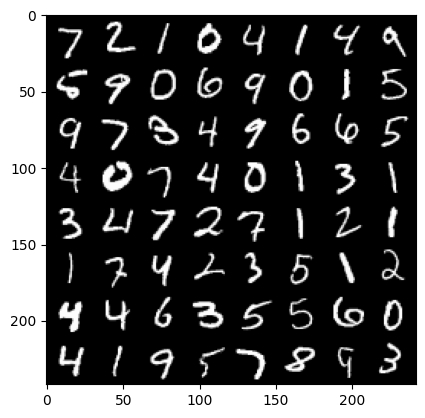

Reconstructed Images


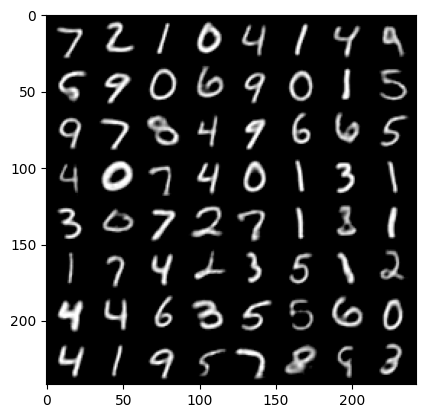

tensor([ 0.1641, -0.0036,  0.2152, -0.1089,  0.0091, -0.0348,  0.0433, -0.0244,
         0.1238, -0.0455, -0.0586,  0.0681, -0.0616,  0.3480,  0.0026, -0.2178,
        -0.0403,  0.0503, -0.0152,  0.0434, -0.0921,  0.0168,  0.0550, -0.1308,
        -0.0099, -0.0115,  0.0205, -0.0746,  0.1166,  0.1009, -0.0628,  0.0513,
         0.0531, -0.0510, -0.0401, -0.0517, -0.0271,  0.0668, -0.2218, -0.2254,
        -0.0339, -0.0573, -0.0075, -0.0520,  0.0990,  0.2345,  0.1248,  0.0229,
         0.0571, -0.0986])
tensor(11)


In [9]:
# Get a batch of test images
images, _ = next(iter(mnist_dm.val_dataloader()))


# Get the reconstructed images
vae.eval()
with torch.no_grad():
    reconstructed, _, _, latent = vae(images)

# Show original images
print("Original Images")
imshow(torchvision.utils.make_grid(images))

# Show reconstructed images
print("Reconstructed Images")
imshow(torchvision.utils.make_grid(reconstructed))

# save the images and the corresponding reconstructions
torchvision.utils.save_image(images, "original.png")
torchvision.utils.save_image(reconstructed, "reconstructed.png")

# compute the rank of the latent matrix
rank = torch.linalg.matrix_rank(latent)
print(latent[2])
print(rank)